## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

      1 [main] wget 10268 find_fast_cwd: WARNING: Couldn't compute FAST_CWD pointer.  Please report this problem to
the public mailing list cygwin@cygwin.com
--2021-11-24 15:08:49--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
ERROR: cannot verify www.dropbox.com's certificate, issued by `/C=US/O=DigiCert Inc/OU=www.digicert.com/CN=DigiCert SHA2 High Assurance Server CA':
  Unable to locally verify the issuer's authority.
To connect to www.dropbox.com insecurely, use `--no-check-certificate'.


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 1
# Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. 
# Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

N = 12000
f = open('data_000637.txt', 'r')
data = pd.read_csv(f, nrows=N)
df = pd.DataFrame(data)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
11995,1,0,139,3869200286,3251,0
11996,1,0,62,3869200286,3246,4
11997,1,0,58,3869200286,3246,11
11998,1,0,61,3869200286,3251,17


In [4]:
# 2
# Find out the number of BX in a ORBIT (the value 'x').
x = df["BX_COUNTER"].max() - df["BX_COUNTER"].min()
x

3563

In [23]:
# 3
# Find out how much the data taking lasted. 
# You can either make an estimate based on the fraction of the measurements (rows) you read,
# or perform this check precisely by reading out the whole dataset.

def time_ns(orbit, bx, tdc, x = 3563):
    return (orbit * x + bx) * 25 + tdc * 25 / 30

f = open('data_000637.txt', 'r')
data = pd.read_csv(f)
orbits = int(data["ORBIT_CNT"].tail(1)) - data["ORBIT_CNT"][0]
start = time_ns(data["ORBIT_CNT"][0], data["BX_COUNTER"][0], data["TDC_MEAS"][0])
end = time_ns(int(data["ORBIT_CNT"].tail(1)), int(data["BX_COUNTER"].tail(1)), int(data["TDC_MEAS"].tail(1)))
duration = end - start
print(f"Total time was {duration} nanonseconds ({round(duration / 10e6, 2)} milliseconds).")

Total time was 980140993.3125 nanonseconds (98.01 milliseconds).


In [ ]:
# 4
# Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).
abs_times = [time_ns(row[1]['ORBIT_CNT'], row[1]['BX_COUNTER'], row[1]['TDC_MEAS']) for row in data.iterrows()]
data['ABS_TIME'] = abs_times

In [63]:
# 5
# Replace the values (all 1) of the HEAD column randomly with 0 or 1.
for row in df.iterrows():
    df['HEAD'][row[0]] = np.random.randint(2)


In [57]:
# 6 
# Create a new DataFrame that contains only the rows with HEAD=1.
newdf = df[df["HEAD"] == 1]
newdf

In [153]:
def sum_even_numbers():
    sum = 0
    for i in range(0, 100):
        
        if i % 2 == 0:
            print(i)
            sum += i
    return sum

print(sum_even_numbers())

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
2450


Text(0.5, 0.98, 'Occurancy plots')

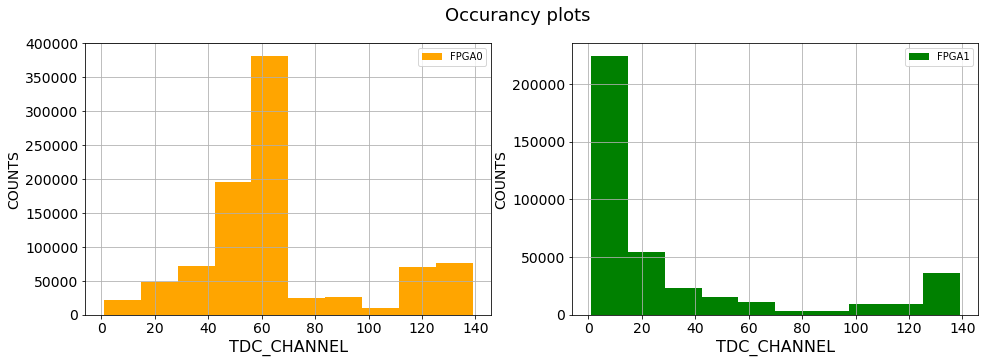

In [151]:
# 7
# Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel
df_fpga0 = data[data['FPGA'] == 0]
df_fpga1 = data[data['FPGA'] == 1]
%matplotlib inline
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
ax0.hist(df_fpga0['TDC_CHANNEL'], label='FPGA0', color='orange')
ax0.legend()
ax0.grid()
ax0.set_xlabel('TDC_CHANNEL', fontsize=16)
ax0.set_ylabel('COUNTS', fontsize=14)
ax0.tick_params(labelsize=14)
ax1.hist(df_fpga1['TDC_CHANNEL'], label='FPGA1', color='green')
ax1.legend()
ax1.grid()
ax1.set_xlabel('TDC_CHANNEL', fontsize=16)
ax1.set_ylabel('COUNTS', fontsize=14)
ax1.tick_params(labelsize=14)
fig.suptitle('Occurancy plots', fontsize=18)

In [147]:
# 8 
# Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)
top3 = data.groupby(['TDC_CHANNEL']).count().sort_values('HEAD')
top3.tail(3)

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
TDC_CHANNEL,,,,,,
63,64642,64642,64642,64642,64642,64642
64,66020,66020,66020,66020,66020,66020
139,108059,108059,108059,108059,108059,108059


In [146]:
# 9 
# Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
unique_orbits = data['ORBIT_CNT'].unique()
print('the number of unique orbits is', len(unique_orbits))
unique_orbits_139 = data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'].unique()
print('the number of unique orbits with at least one measurement from TDC_CHANNEL=139 is', len(unique_orbits_139))

the number of unique orbits is 11001
the number of unique orbits with at least one measurement from TDC_CHANNEL=139 is 10976
